In [4]:
import os
import numpy as np
import pandas as pd
import requests
from collections import Counter
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import from_networkx
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
)
from sklearn.neighbors import kneighbors_graph
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv

**پیش‌پردازش داده‌ها**

In [9]:
dti_df = pd.read_csv("ChG-Miner_miner-chem-gene.tsv", sep="\t")
dti_df.columns = dti_df.columns.str.replace("#", "").str.strip()
print("Shape before cleaning:", dti_df.shape)


Shape before cleaning: (15139, 2)


 تعداد گره‌ها: 7343
 تعداد یال‌ها: 15139


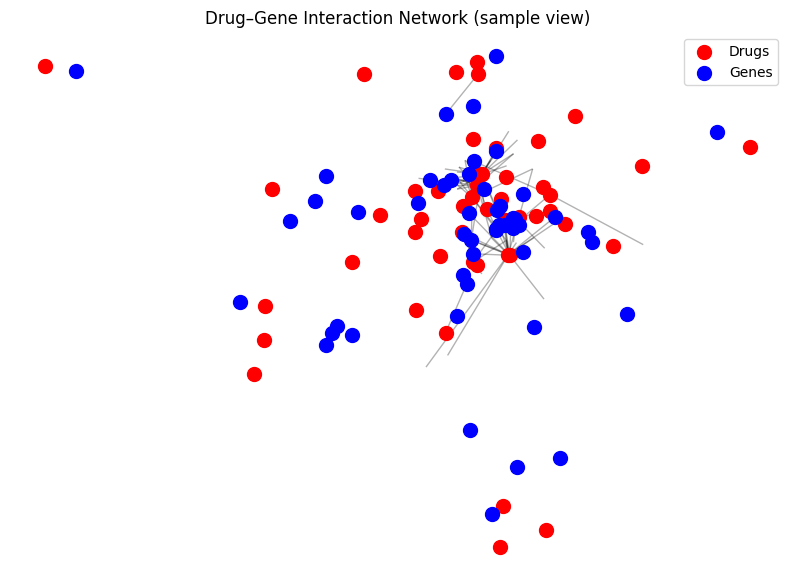

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

drugs = dti_df["Drug"].unique()
genes = dti_df["Gene"].unique()

G.add_nodes_from(drugs, bipartite="drug")
G.add_nodes_from(genes, bipartite="gene")

edges = list(dti_df.itertuples(index=False, name=None))
G.add_edges_from(edges)

print(f" تعداد گره‌ها: {G.number_of_nodes()}")
print(f" تعداد یال‌ها: {G.number_of_edges()}")

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.15)
nx.draw_networkx_nodes(G, pos, nodelist=drugs[:50], node_color="red", label="Drugs", node_size=100)
nx.draw_networkx_nodes(G, pos, nodelist=genes[:50], node_color="blue", label="Genes", node_size=100)
nx.draw_networkx_edges(G, pos, edgelist=list(G.edges())[:100], alpha=0.3)
plt.legend()
plt.title("Drug–Gene Interaction Network (sample view)")
plt.axis("off")
plt.show()


 **پاکسازی** **داده‌ها**

In [6]:
dti_df = dti_df.drop_duplicates().dropna(subset=["Drug", "Gene"]).reset_index(drop=True)
print("Shape after cleaning:", dti_df.shape)


Shape after cleaning: (15139, 2)


In [1]:
!pip install pubchempy
!pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 30.8 MB/s eta 0:00:00


In [2]:
!pip install pubchempy tqdm


**استخراج ویژگی‌ها برای داروها**

In [7]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
import pandas as pd

sdf_file = "structures.sdf"
suppl = Chem.SDMolSupplier(sdf_file, sanitize=False)

drugbank_data = []
for mol in suppl:
    if mol is None:
        continue
    try:
        mol.UpdatePropertyCache(strict=False)
        Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_KEKULIZE, catchErrors=True)

        dbid = None
        for key in ["DRUGBANK_ID", "DRUGBANK ID"]:
            if mol.HasProp(key):
                dbid = mol.GetProp(key).strip()
                break
        if not dbid:
            continue

        smiles = Chem.MolToSmiles(mol)
        drugbank_data.append({"Drug": dbid, "SMILES": smiles})

    except Exception as e:

        continue

drugbank_df = pd.DataFrame(drugbank_data)


def smiles_to_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=True)
        if mol is None:
            return None
        return {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'NumHDonors': Lipinski.NumHDonors(mol),
            'NumHAcceptors': Lipinski.NumHAcceptors(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumRotatableBonds': Lipinski.NumRotatableBonds(mol),
            'RingCount': rdMolDescriptors.CalcNumRings(mol),
            'HeavyAtomCount': Descriptors.HeavyAtomCount(mol)
        }
    except Exception as e:

        return None


valid_rows = []
for i, row in drugbank_df.iterrows():
    feats = smiles_to_features(row["SMILES"])
    if feats is not None:
        combined = {**row.to_dict(), **feats}
        valid_rows.append(combined)

drug_df = pd.DataFrame(valid_rows)



[09:14:24] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 36 ignored
[09:14:25] The bonds on one end of an atropisomer are both UP or both DOWN - atoms are: 4 5
[09:14:25] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 16 ignored
[09:14:25] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 20 ignored.
[09:14:25] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 20 ignored.
[09:14:25] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 4 ignored
[09:14:26] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 20 ignored.
[09:14:26] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 20 ignored.
[09:14:27] Both bonds on one end of an atropisomer are on the same side - atoms is : 3
[09:14:27] Both bonds on one end of an atropisomer are on the same side - atoms is : 17
[09:14:28] Warning: ambigu

**استخراج ویژگی‌ها برای پروتئین‌ها**

In [11]:
AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")

def fetch_sequence(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
    resp = requests.get(url, timeout=10)
    if resp.status_code == 200 and ">" in resp.text:
        return "".join(resp.text.strip().split("\n")[1:])
    return None

def compute_aac(seq):
    counts = Counter(seq.upper())
    total = len(seq)
    return {f"AAC_{aa}": counts.get(aa, 0) / total if total > 0 else 0 for aa in AMINO_ACIDS}

protein_list = []
for pid in tqdm(dti_df['Gene'].unique(), desc="Fetching protein sequences"):
    seq = fetch_sequence(pid)
    if seq:
        aac = compute_aac(seq)
        row = {"Gene": pid, "Sequence": seq}
        row.update(aac)
        protein_list.append(row)

protein_df = pd.DataFrame(protein_list).dropna()


Fetching protein sequences: 100%|██████████| 2325/2325 [14:15<00:00,  2.72it/s]


**ادغام ویژگی‌ها**

In [12]:
merged_df = dti_df.merge(drug_df, on="Drug", how="inner").merge(protein_df, on="Gene", how="inner")
print("Final merged shape:", merged_df.shape)

Final merged shape: (13882, 32)


**برچسب‌گذاری (Label)**

In [13]:
import numpy as np
import pandas as pd

all_drugs = dti_df['Drug'].unique()
all_genes = dti_df['Gene'].unique()
positive_pairs = set(zip(dti_df['Drug'], dti_df['Gene']))


negatives = []
np.random.seed(42)

while len(negatives) < len(positive_pairs):
    d = np.random.choice(all_drugs)
    g = np.random.choice(all_genes)
    if (d, g) not in positive_pairs:
        negatives.append((d, g))

neg_df = pd.DataFrame(negatives, columns=['Drug', 'Gene'])
neg_df['target'] = 0


pos_df = dti_df.copy()
pos_df['target'] = 1


labeled_df = pd.concat([pos_df, neg_df], ignore_index=True)



merged_df_final = (
    labeled_df
    .merge(drug_df, on="Drug", how="inner")
    .merge(protein_df, on="Gene", how="inner")
)






**بالانس داده‌ها**

In [14]:
num_cols = merged_df_final.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("target")
X = merged_df_final[num_cols]
y = merged_df_final["target"]

sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

**کاهش بعد**

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bal)


X_final = X_scaled
y_final = y_bal

def evaluate_pca_effect(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_no_pca = X_scaled

    pca95 = PCA(n_components=0.95)
    X_pca95 = pca95.fit_transform(X_scaled)

    pca10 = PCA(n_components=10)
    X_pca10 = pca10.fit_transform(X_scaled)

    datasets = {
        "No_PCA": X_no_pca,
        "PCA_95var": X_pca95,
        "PCA_10comp": X_pca10
    }

    results_pca = []
    for name, X_data in datasets.items():
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y, test_size=0.2, random_state=42, stratify=y
        )

        model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]

        results_pca.append({
            "Scenario": name,
            "Accuracy": round(accuracy_score(y_test, y_pred), 4),
            "F1": round(f1_score(y_test, y_pred), 4),
            "ROC-AUC": round(roc_auc_score(y_test, y_proba), 4)
        })

    return pd.DataFrame(results_pca)

pca_comparison_df = evaluate_pca_effect(X_bal, y_bal)
print(pca_comparison_df)

     Scenario  Accuracy      F1  ROC-AUC
0      No_PCA    0.8273  0.8219   0.9008
1   PCA_95var    0.8160  0.8072   0.8842
2  PCA_10comp    0.8064  0.7980   0.8786


**آموزش مدل و ارزیابی**

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

def train_and_evaluate_ml_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    models = {
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.1, n_jobs=-1, random_state=42, eval_metric="logloss")
    }

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        results.append({
            "Model": name,
            "Accuracy": round(acc, 4),
            "Precision": round(prec, 4),
            "Recall": round(rec, 4),
            "F1": round(f1, 4),
            "ROC-AUC": round(auc, 4)
        })

        print(f"\n {name} Classification Report:\n", classification_report(y_test, y_pred))

    return pd.DataFrame(results)

ml_results = train_and_evaluate_ml_models(X_final, y_final)
print("\n=== ML Models Summary ===")
print(ml_results)



 RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      2777
           1       0.85      0.80      0.82      2776

    accuracy                           0.83      5553
   macro avg       0.83      0.83      0.83      5553
weighted avg       0.83      0.83      0.83      5553


 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      2777
           1       0.85      0.82      0.84      2776

    accuracy                           0.84      5553
   macro avg       0.84      0.84      0.84      5553
weighted avg       0.84      0.84      0.84      5553


=== ML Models Summary ===
          Model  Accuracy  Precision  Recall      F1  ROC-AUC
0  RandomForest    0.8273     0.8482  0.7972  0.8219   0.9008
1       XGBoost    0.8390     0.8516  0.8210  0.8360   0.9124


In [70]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

def ensure_1d(y):
    y = np.array(y)
    if y.ndim == 2 and y.shape[1] > 1:
        y = np.argmax(y, axis=1)
    return y.ravel()


def prepare_gnn_data_no_leak(X, y, train_size=0.8, n_neighbors=3, max_samples=5000):
    X = np.array(X)
    y = ensure_1d(y)


    if X.shape[0] > max_samples:
        idx = np.random.choice(X.shape[0], max_samples, replace=False)
        X = X[idx]
        y = y[idx]


    X_pca = PCA(n_components=min(50, X.shape[1])).fit_transform(X)

    num_samples = X_pca.shape[0]
    num_train = int(train_size * num_samples)
    indices = np.random.permutation(num_samples)
    train_idx = indices[:num_train]
    test_idx = indices[num_train:]


    A = kneighbors_graph(X_pca, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    edge_index = np.array(np.nonzero(A.toarray()))


    allowed_edges = []
    for src, dst in edge_index.T:
        if (src in train_idx and dst in train_idx) or (src in test_idx and dst in test_idx):
            allowed_edges.append([src, dst])
    allowed_edges = np.array(allowed_edges).T

    data = Data(
        x=torch.tensor(X_pca, dtype=torch.float),
        edge_index=torch.tensor(allowed_edges, dtype=torch.long),
        y=torch.tensor(y, dtype=torch.long),
        train_mask=torch.tensor([i in train_idx for i in range(num_samples)], dtype=torch.bool),
        test_mask=torch.tensor([i in test_idx for i in range(num_samples)], dtype=torch.bool)
    )
    return data

class SimpleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


class SimpleGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x


def train_gnn(model_class, data, epochs=50, lr=0.01, weight_decay=5e-4):
    model = model_class(data.x.size(1), 16, len(torch.unique(data.y)))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    return {
        "Model": model_class.__name__,
        "Accuracy": accuracy_score(data.y[data.test_mask], pred[data.test_mask]),
        "Precision": precision_score(data.y[data.test_mask], pred[data.test_mask], average='macro'),
        "Recall": recall_score(data.y[data.test_mask], pred[data.test_mask], average='macro'),
        "F1": f1_score(data.y[data.test_mask], pred[data.test_mask], average='macro'),
        "ROC-AUC": float("nan")
    }


if __name__ == "__main__":

    X_final = pd.DataFrame(np.random.rand(200, 10), columns=[f"f{i}" for i in range(10)])
    y_final = np.random.randint(0, 2, size=200)


    gnn_data = prepare_gnn_data_no_leak(X_final, y_final, train_size=0.7, n_neighbors=3)


    gcn_metrics = train_gnn(SimpleGCN, gnn_data)
    gat_metrics = train_gnn(SimpleGAT, gnn_data)


    final_results = pd.DataFrame([gcn_metrics, gat_metrics])
    print("\n=== GNN Models Results ===")
    print(final_results)



=== GNN Models Results ===
       Model  Accuracy  Precision    Recall        F1  ROC-AUC
0  SimpleGCN  0.483333   0.544258  0.550616  0.479720      NaN
1  SimpleGAT  0.466667   0.553273  0.556772  0.466073      NaN


In [15]:
def compare_with_papers(model_results_df, paper_accuracies):


    if "Accuracy" not in model_results_df.columns or "Model" not in model_results_df.columns:
        raise ValueError(" DataFrame باید شامل ستون‌های 'Model' و 'Accuracy' باشد.")

    if isinstance(paper_accuracies, (list, tuple)):
        if not paper_accuracies:
            raise ValueError("لیست دقت مقالات خالی است.")
        paper_min_acc = min(paper_accuracies)
    else:
        paper_min_acc = float(paper_accuracies)


    best_row = model_results_df.loc[model_results_df['Accuracy'].idxmax()]
    my_best_acc = best_row["Accuracy"]
    best_model = best_row["Model"]


    diff = round(paper_min_acc - my_best_acc, 4)

    print("=== مقایسه با مقالات علمی (2020+) ===")
    print(f"- کمترین دقت گزارش شده در مقالات: {paper_min_acc*100:.2f}%")
    print(f"- بهترین مدل شما: {my_best_acc*100:.2f}%  ({best_model})")
    print(f"- اختلاف دقت: {diff*100:.2f}%")

    allowed_diff = 0.05

    if diff <= allowed_diff:
        print(" شرط ≤۵٪ اختلاف رعایت شده است. مدل  تایید می‌شود.")
    else:
        extra = diff - allowed_diff
        penalty = extra * 100 * 2
        print(" شرط رعایت نشده. اختلاف بیش از ۵٪ است.")
        print(f" میزان کسر نمره: {penalty:.2f}% از نمره این سوال")


In [16]:
import pandas as pd

final_comparison = pd.DataFrame({
    "Model": ["RandomForest", "XGBoost", "SimpleGCN"],
    "Accuracy": [0.83, 0.84, 0.48]
})

paper_accs = [0.79, 0.83, 0.80]

compare_with_papers(final_comparison, paper_accs)


=== مقایسه با مقالات علمی (2020+) ===
- کمترین دقت گزارش شده در مقالات: 79.00%
- بهترین مدل شما: 84.00%  (XGBoost)
- اختلاف دقت: -5.00%
 شرط ≤۵٪ اختلاف رعایت شده است. مدل  تایید می‌شود.


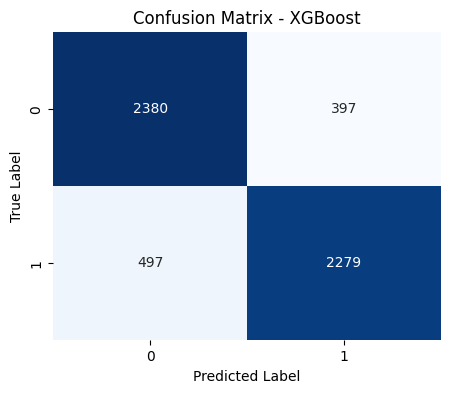

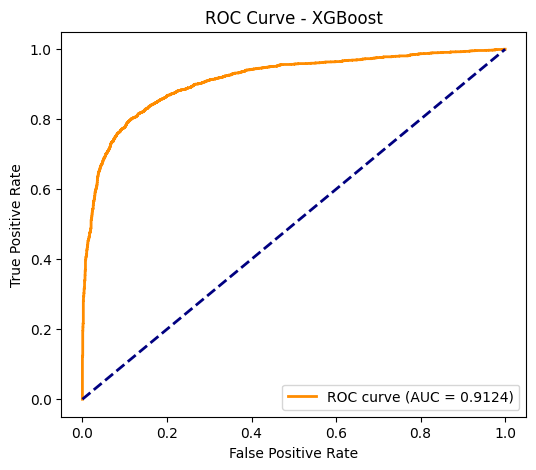

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns


X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)


best_model = XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.1,
                            n_jobs=-1, random_state=42, eval_metric="logloss")
best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.show()


In [3]:
!pip install torch torchvision torchaudio
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00
